In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
import time
from copy import deepcopy # Add Deepcopy for args
import seaborn as sns 
import matplotlib.pyplot as plt

# Data Preparation

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
partition = {'train': trainset, 'val':valset, 'test':testset}

Files already downloaded and verified
Files already downloaded and verified


# Model Architecture

In [5]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

In [22]:
class CNN(nn.Module):
    
    def __init__(self, model_code, in_channels, out_dim, act, use_bn):
        super(CNN, self).__init__()
        
        if act == 'relu':
            self.act = nn.ReLU()
        elif act == 'sigmoid':
            self.act = nn.Sigmoid()
        elif act == 'tanh':
            self.act = nn.Tanh()
        else:
            raise ValueError("Not a valid activation function code")
        
        self.layers = self._make_layers(model_code, in_channels, use_bn)
        self.classifer = nn.Sequential(nn.Linear(512, 256),
                                       self.act,
                                       nn.Linear(256, out_dim))
        
    def forward(self, x):
        x = self.layers(x)
        x = x.view(x.size(0), -1)
        x = self.classifer(x)
        return x
        
    def _make_layers(self, model_code, in_channels, use_bn):
        layers = []
        for x in cfg[model_code]:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels=in_channels,
                                     out_channels=x,
                                     kernel_size=3,
                                     stride=1,
                                     padding=1)]
                if use_bn:
                    layers += [nn.BatchNorm2d(x)]
                layers += [self.act]
                in_channels = x
        return nn.Sequential(*layers)

In [23]:
class CNN1(nn.Module): # 연습
    
    def __init__(self):
        super(CNN1, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels = 3,
                               out_channels = 64,
                               kernel_size = 3,
                               stride = 1,
                               padding = 1)
        self.conv2 = nn.Conv2d(in_channels = 64,
                               out_channels = 256,
                               kernel_size = 5,
                               stride = 1,
                               padding = 2)
        self.act = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2,
                                     stride = 2)
        self.fc = nn.Linear(65536, 10) # 65536 = 256 * 8 * 8 / Output dimension = 10

    def forward(self, x):
        x = self.conv1(x)
        x = self.act(x)
        x = self.conv2(x)
        x = self.act(x)
        x = self.maxpool1(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
     

In [24]:
def dimension_check():
    net = CNN('VGG11', 3, 10, 'relu', True)
    x = torch.randn(2, 3, 32, 32)
    y = net(x)
    print(y.size()) # Neural Network Output Size

dimension_check()

torch.Size([2, 10])


In [25]:
def dimension_check():
    net = CNN1()
    x = torch.randn(2, 3, 32, 32)
    y = net(x)
    print(y.size()) # Neural Network Output Size

dimension_check()

torch.Size([2, 10])


# Experiment Preparation

In [26]:
from utils.experiment import *
from utils.report import *
from utils.plot import *

In [27]:
def experiment(partition, args):
  
    net = CNN(model_code = args.model_code,
              in_channels = args.in_channels,
              out_dim = args.out_dim,
              act = args.act,
              use_bn = args.use_bn)
    net.cuda()

    criterion = nn.CrossEntropyLoss()
    if args.optim == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')
    
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
        
    for epoch in range(args.epoch):  # loop over the dataset multiple times
        ts = time.time()
        net, train_loss, train_acc = train(net, partition, optimizer, criterion, args)
        val_loss, val_acc = validate(net, partition, criterion, args)
        te = time.time()
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.2f}/{:2.2f}. Took {:2.2f} sec'.format(epoch, train_acc, val_acc, train_loss, val_loss, te-ts))
        
    test_acc = test(net, partition, args)  
    print('Test acc: {}'.format(test_acc)) 
    
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    return vars(args), result

# Experiment

In [30]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp1_lr_model_code"

# ====== Model ====== #
args.model_code = 'VGG11'
args.in_channels = 3
args.out_dim = 10
args.act = 'relu'

# ====== Regularization ======= #
args.l2 = 0.00001
args.use_bn = True

# ====== Optimizer & Training ====== #
args.optim = 'Adam' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.005
args.epoch = 10

args.train_batch_size = 256
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'lr'
name_var2 = 'model_code'
list_var1 = [0.001, 0.0001]
list_var2 = ['VGG11', 'VGG13', 'VGG16']


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

Namespace(exp_name='exp1_lr_model_code', model_code='VGG11', in_channels=3, out_dim=10, act='relu', l2=1e-05, use_bn=True, optim='Adam', lr=0.001, epoch=10, train_batch_size=256, test_batch_size=1024)
Epoch 0, Acc(train/val): 45.04/53.73, Loss(train/val) 1.44/1.32. Took 5.13 sec
Epoch 1, Acc(train/val): 65.95/63.56, Loss(train/val) 0.94/1.02. Took 4.99 sec
Epoch 2, Acc(train/val): 74.44/68.10, Loss(train/val) 0.73/0.94. Took 5.00 sec
Epoch 3, Acc(train/val): 79.52/71.21, Loss(train/val) 0.58/0.87. Took 4.97 sec
Epoch 4, Acc(train/val): 83.12/75.52, Loss(train/val) 0.48/0.74. Took 4.85 sec
Epoch 5, Acc(train/val): 86.85/76.07, Loss(train/val) 0.38/0.75. Took 5.02 sec
Epoch 6, Acc(train/val): 89.50/77.31, Loss(train/val) 0.30/0.76. Took 4.88 sec
Epoch 7, Acc(train/val): 91.55/78.41, Loss(train/val) 0.24/0.69. Took 5.06 sec
Epoch 8, Acc(train/val): 93.73/78.12, Loss(train/val) 0.19/0.85. Took 4.96 sec
Epoch 9, Acc(train/val): 94.61/79.34, Loss(train/val) 0.15/0.75. Took 4.87 sec
Test acc:

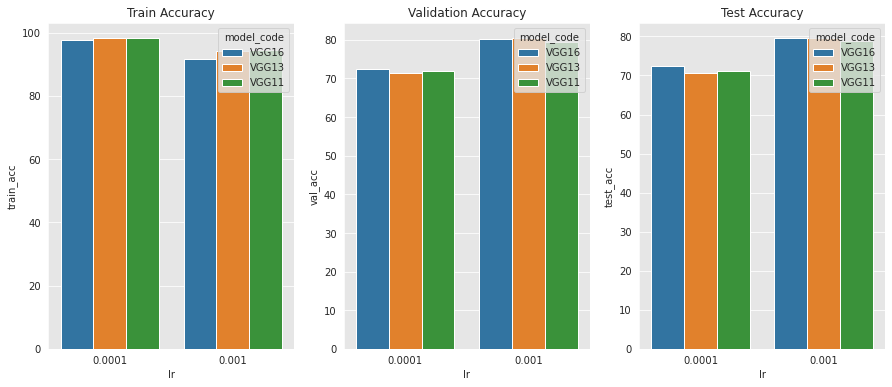

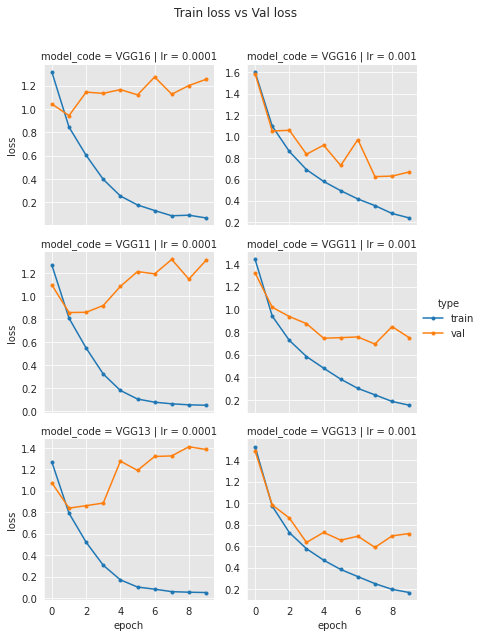

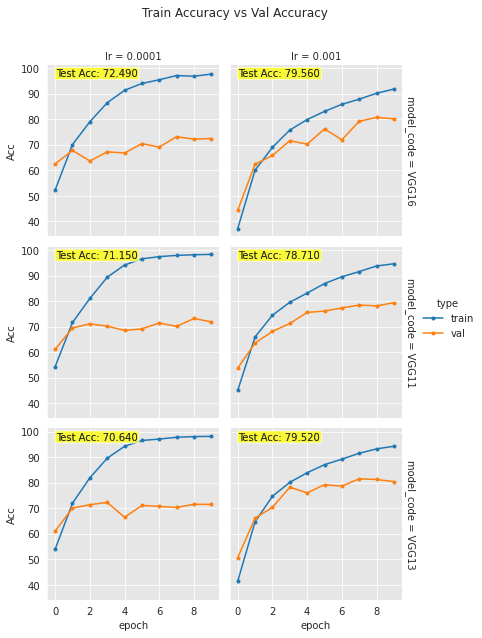

In [33]:
var1 = 'lr'
var2 = 'model_code'
df = load_exp_result('exp1_lr_model')

plot_acc(var1, var2, df)
plot_loss_variation(var1, var2, df, sharey=False) #sharey를 True로 하면 모둔 subplot의 y축의 스케일이 같아집니다.
plot_acc_variation(var1, var2, df, margin_titles=True, sharey=True) #margin_titles를 True로 하면 그래프의 가장자리에 va